### 1. Imports

In [22]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### 1.2 Import the data

In [71]:
path = 'dataset/A_DeviceMotion_data/'

list_of_folders = os.listdir(path)
list_of_directories = [path + i for i in list_of_folders]
list_of_dfs = []

activities = ['dws', 'ups', 'sit', 'std', 'wlk', 'jog']

for i in list_of_directories:
    if i == path + '.DS_Store':
        continue

    list_of_csv = os.listdir(i)
    list_of_csv = [m for m in list_of_csv if m.endswith('.csv')]
    for j in list_of_csv:
        k = pd.read_csv(i + '/' + j).rename(columns={'Unnamed: 0': 'time'})
        k['subject'] = int(j.split('_')[1].split('.')[0])
        k['activity'] = i.split('/')[2].split('_')[0]
        k['trial'] = int(i.split('/')[2].split('_')[1])
        
        list_of_dfs.append(k)

df = pd.concat(list_of_dfs, ignore_index=True).set_index('time')
df = df.rename(columns={'rotationRate.x': 'gyro_x', 'rotationRate.y': 'gyro_y', 'rotationRate.z': 'gyro_z'})

df.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,gyro_x,gyro_y,gyro_z,userAcceleration.x,userAcceleration.y,userAcceleration.z,subject,activity,trial
time,,,,,,,,,,,,,,,
0,-2.116381,-1.077507,-2.261502,-0.404768,0.880780,0.245713,-1.264215,-1.027909,-0.947909,0.282683,-0.254346,-0.407670,12,dws,11
1,-2.148154,-1.049759,-2.284278,-0.417081,0.867303,0.271686,-1.162024,-0.269118,-0.848823,0.256712,0.079154,-0.560291,12,dws,11
2,-2.153824,-1.026749,-2.297008,-0.432082,0.855621,0.284961,-0.665042,0.520170,-0.726722,0.253600,0.346680,-0.463275,12,dws,11
3,-2.142509,-1.012749,-2.290595,-0.445311,0.848291,0.286507,-0.079809,0.055322,-0.604534,0.411818,0.459372,-0.510293,12,dws,11
4,-2.130486,-1.007262,-2.274149,-0.452661,0.845372,0.283600,0.456097,-0.186877,-0.441315,0.311594,0.477305,-0.925049,12,dws,11


### 1.3 Data Preprocessing

#### 1.3.0 Feature engineering

In [72]:

# combine dfs and drop unnecessary columns

df.insert(0, 'accel_x', df["userAcceleration.x"] + df["gravity.x"])
df.insert(1, 'accel_y', df["userAcceleration.y"] + df["gravity.y"])
df.insert(2, 'accel_z', df["userAcceleration.z"] + df["gravity.z"])
df.insert(3, 'accel_norm', np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2))

# drop userAcceleration and gravity columns since we have combined them
# PCA shows that with these colums we can reduce the dimensionality of the data and without them, we cannot
df.drop(['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'gravity.x', 'gravity.y', 'gravity.z'], axis=1, inplace=True)

print(df.head())

df_X = df.iloc[:, :-3]
df_y = df.iloc[:, -3:]

       accel_x   accel_y   accel_z  accel_norm  attitude.roll  attitude.pitch  \
time                                                                            
0    -0.122085  0.626434 -0.161957    0.658448      -2.116381       -1.077507   
1    -0.160369  0.946457 -0.288605    1.002393      -2.148154       -1.049759   
2    -0.178482  1.202301 -0.178314    1.228487      -2.153824       -1.026749   
3    -0.033493  1.307663 -0.223786    1.327096      -2.142509       -1.012749   
4    -0.141067  1.322677 -0.641449    1.476764      -2.130486       -1.007262   

      attitude.yaw    gyro_x    gyro_y    gyro_z  subject activity  trial  
time                                                                       
0        -2.261502 -1.264215 -1.027909 -0.947909       12      dws     11  
1        -2.284278 -1.162024 -0.269118 -0.848823       12      dws     11  
2        -2.297008 -0.665042  0.520170 -0.726722       12      dws     11  
3        -2.290595 -0.079809  0.055322 -0.604534    

#### 1.3.4 Data correlation

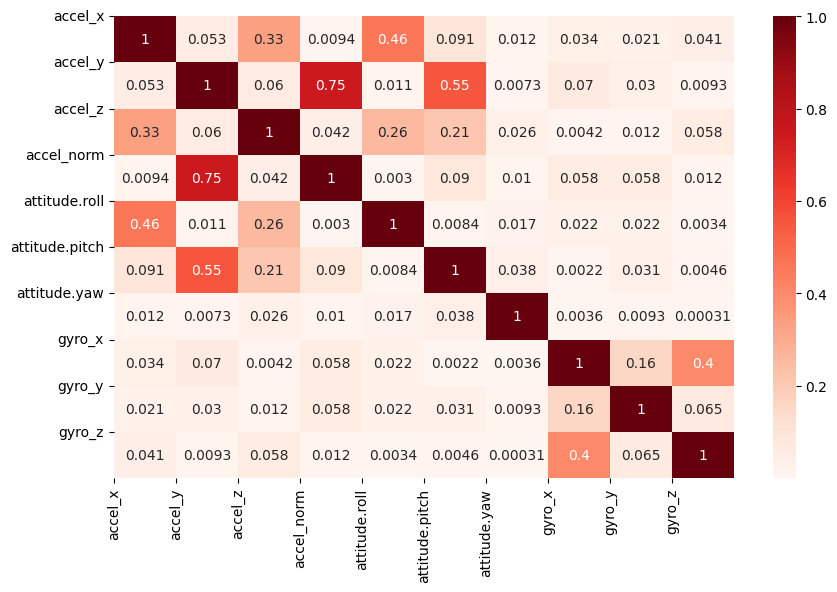

In [73]:
import seaborn as sns
correlation_matrix = df_X.corr()
correlation_matrix = correlation_matrix.abs()

# visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

#### Feature selection

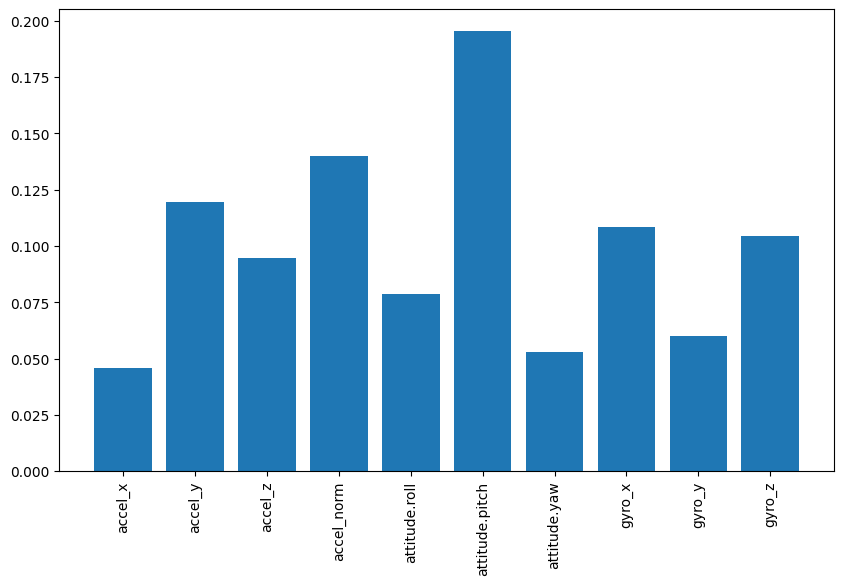

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=15)
clf.fit(df_X, df_y.activity)

feature_importance = clf.feature_importances_

# visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(df_X.columns, feature_importance)
plt.xticks(rotation=90)
plt.show()

##### 1.3.1 Data scaling

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def minmax_scaling(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

def standard_scaling(df):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    return df_scaled

##### 1.3.2 Graph the best number of components to use

In [32]:
from sklearn.decomposition import PCA

def pca_best_components(df):
    X = df.iloc[:,:-3]
    normalized_X = (X - X.mean()) / X.std()
    # apply PCA
    pca = PCA()
    pca.fit(normalized_X)

    explained_variance = pca.explained_variance_ratio_

    # visualize explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance))
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Number of Components')
    plt.title('Explained Variance by Principal Components')
    plt.grid()
    plt.show()

    # find the number of components that explain 95% of the variance
    cumsum = np.cumsum(explained_variance)
    best_n_components = np.argmax(cumsum >= 0.95) + 1
    print("Best number of components:", best_n_components)
    return best_n_components

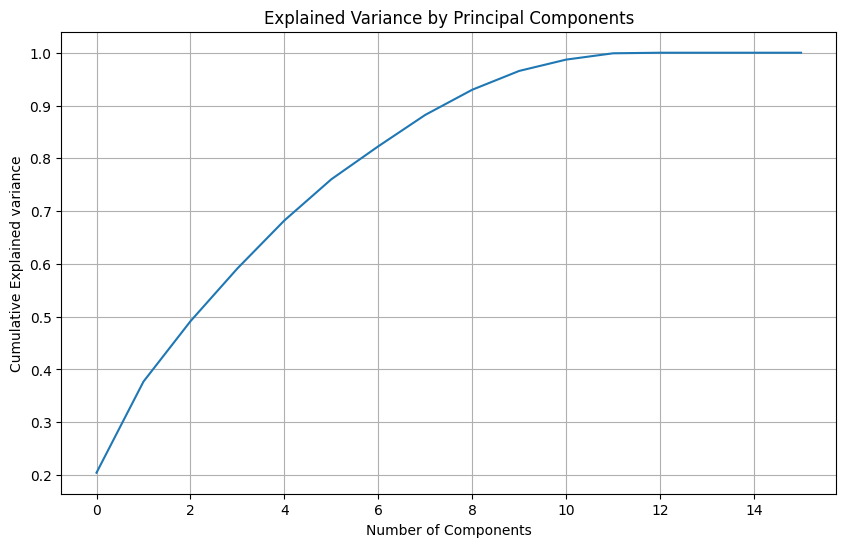

Best number of components: 10


In [42]:
best_n_c = pca_best_components(df)

if best_n_c == len(df_X.columns):
    print("PCA not needed")

In [106]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#### 1.3.3 Simple Test train split

In [74]:
def y_to_categorical(y_train):
    encoder = LabelEncoder()
    encoder.fit(y_train)

    y_catagorical = encoder.transform(y_train)
    y_catagorical = to_categorical(y_catagorical)

    return y_catagorical

In [75]:
train_df = df[(df.trial < 10)]
test_df = df[(df.trial >= 10)]


# all except last 3 cols (activity, subject, trial)
X_train = train_df.iloc[:,:-3]
y_train = train_df.activity

y_catagorical = y_to_categorical(y_train)

### 1.3 Data Analysis

1.3.1 Decision Tree

In [76]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [77]:
def test_results(model, df, scaling_func=None):
    correct = 0
    total = 0

    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        if scaling_func:
            k = scaling_func(k)
        preds = model.predict(k)
        print(i + ': ' + str(((preds == i).sum() / len(preds))*100) + '%')
        correct += (preds == i).sum()
        total += len(preds)
    print('Total: ' + str((correct / total)*100) + '%')

In [78]:
test_results(dtc, test_df)

dws: 48.057950404408494%
ups: 51.72623085436824%
sit: 94.70327791703883%
std: 90.3395375623384%
wlk: 59.19230297830617%
jog: 60.4601391118245%
Total: 76.74605257996674%


### 1.3.1.1 Decision Tree with scaling

In [30]:
dtc = DecisionTreeClassifier()
X_scaled = minmax_scaling(X_train)
dtc.fit(X_scaled, y_train)

test_results(dtc, test_df, minmax_scaling)

dws: 10.301306550528842%
ups: 16.48041700881859%
sit: 2.4442715686556986%
std: 0.020830525296834986%
wlk: 21.889937492339747%
jog: 46.08747993579455%
Total: 11.33489630950549%


In [31]:
dtc = DecisionTreeClassifier()
X_scaled = standard_scaling(X_train)
dtc.fit(X_scaled, y_train)

test_results(dtc, test_df, standard_scaling)

dws: 30.566171895831484%
ups: 43.11471312792317%
sit: 8.979936804295003%
std: 6.080062736640894%
wlk: 51.02647383257752%
jog: 17.007758159443554%
Total: 21.621572691969984%


Scaling is probably a bad idea due to the fact that we are dealing with time series data, the scaling could interrupt the models' ability to capture patterns over time

### 2.2 Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [39]:
test_results(rfc, test_df)

dws: 62.74108968091725%
ups: 59.14170445214039%
sit: 94.96259160015751%
std: 92.56472779404737%
wlk: 70.39772030886138%
jog: 71.7328785446763%
Total: 82.22310730525408%


#### NN testing

In [95]:
import tensorflow as tf
from tensorflow import keras

def nn_compile(model, lr):
    optimizer = keras.optimizers.legacy.Adam(lr=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

def nn_train(model, train_X, train_y, val_X, val_y):
    early_stopping = keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
    history = model.fit(train_X, train_y, epochs=10, batch_size=200, validation_data=(val_X, val_y), callbacks=[early_stopping])
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.show()

def create_base_nn(input):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[input]),
        keras.layers.Dense(48, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dense(6, activation='softmax')
    ])
    return model

train_X, val_X, train_y, val_y = train_test_split(X_train, y_catagorical, shuffle=True)

In [58]:

# 1 input layer, 1 hidden layer, 6 nodes, softmax activation
model =- create_base_nn(X_train.shape[1])

nn_compile(model, 0.01)
nn_train(model, train_X, train_y, val_X, val_y)

In [79]:
def nn_test_results(model, df):
    correct = 0
    total = 0

    for i in activities:
        k = df.iloc[:,:-3][(df.activity == i)]
        preds = model.predict(k, verbose=0)
        encoder = LabelEncoder()
        encoder.fit(y_train)
        l = []
        for j in range(len(preds)):
            l.append(list(encoder.classes_)[np.argmax(preds[j])])
        accuracy = sum([l[j] == i for j in range(len(l))])/len(l)
        print(i + ': ' + str(accuracy*100) + '%')
        correct += sum([l[j] == i for j in range(len(l))])
        total += len(l)
    print('total: ' + str(correct / total * 100) + '%')

In [65]:
nn_test_results(model, test_df)

dws: 48.04017420673718%
ups: 58.309828983541%
sit: 94.01561644625004%
std: 88.4072000098026%
wlk: 72.51041794337542%
jog: 69.67629748528626%
total: 80.0639070180044%


#### improvement: Rolling features 

In [80]:
def create_feature_columns(k):
    feature_df = df.copy()
    cols = feature_df.iloc[:,:-3].columns

    j = 1
    for i in cols:
        feature_df.insert(j, f"{i}_rmean", feature_df[i].rolling(k).mean())
        feature_df.insert(j+1, f"{i}_rstd", feature_df[i].rolling(k).std())
        feature_df.insert(j+2, f"{i}_rmed", feature_df[i].rolling(k).median())
        j +=4

    for i in range(k):
        feature_df = feature_df.drop([i])

    return feature_df

In [81]:
rolling_df = create_feature_columns(150)

rolling_train_fd = rolling_df[(rolling_df.trial < 10)]
rolling_test_fd = rolling_df[(rolling_df.trial >= 10)]

rolling_X = rolling_train_fd.iloc[:,:-3]
rolling_y = rolling_train_fd.activity

rolling_y_catagorical = y_to_categorical(rolling_y)

In [82]:
rdt = DecisionTreeClassifier()
rdt.fit(rolling_X, rolling_y)

DecisionTreeClassifier()

In [83]:
test_results(rdt, rolling_test_fd)

dws: 89.28155750714211%
ups: 88.68040476873284%
sit: 95.21194576257697%
std: 99.17191165348477%
wlk: 84.17758464132832%
jog: 89.8228406326034%
Total: 92.67862848953745%


In [ ]:
rrfc = RandomForestClassifier(n_estimators=10)
rrfc.fit(rolling_X, rolling_y)

In [ ]:
test_results(rrfc, rolling_test_fd)

Epoch 1/10
3934/3934 [==============================] - 4s 947us/step - loss: 0.3333 - accuracy: 0.9361 - val_loss: 0.1780 - val_accuracy: 0.9790
Epoch 2/10
3934/3934 [==============================] - 4s 980us/step - loss: 0.2231 - accuracy: 0.9672 - val_loss: 0.2235 - val_accuracy: 0.9752
Epoch 3/10
3934/3934 [==============================] - 4s 924us/step - loss: 0.2117 - accuracy: 0.9681 - val_loss: 0.1791 - val_accuracy: 0.9820
Epoch 4/10
3934/3934 [==============================] - 4s 911us/step - loss: 0.2083 - accuracy: 0.9677 - val_loss: 0.1490 - val_accuracy: 0.9825
Epoch 5/10
3934/3934 [==============================] - 4s 922us/step - loss: 0.1966 - accuracy: 0.9688 - val_loss: 0.1460 - val_accuracy: 0.9836
Epoch 6/10
3934/3934 [==============================] - 4s 910us/step - loss: 0.2146 - accuracy: 0.9647 - val_loss: 0.1571 - val_accuracy: 0.9849
Epoch 7/10
3934/3934 [==============================] - 4s 912us/step - loss: 0.2052 - accuracy: 0.9643 - val_loss: 0.1239 -

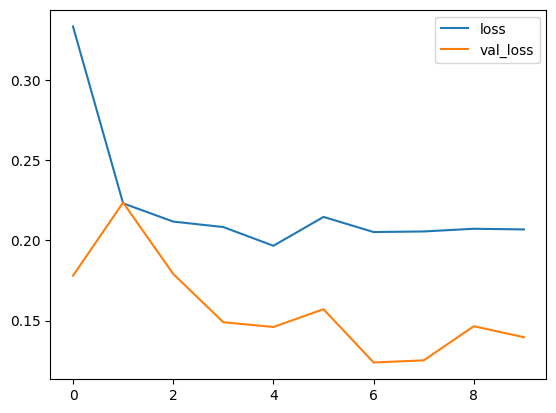

In [96]:
rolling_nn = create_base_nn(rolling_X.shape[1])

train_X, val_X, train_y, val_y = train_test_split(rolling_X, rolling_y_catagorical, shuffle=True)

nn_compile(rolling_nn, 0.01)
nn_train(rolling_nn, train_X, train_y, val_X, val_y)

In [97]:
nn_test_results(rolling_nn, rolling_test_fd)

dws: 98.77261665432229%
ups: 90.66327993772789%
sit: 99.98806219595905%
std: 95.32758200766558%
wlk: 94.71883512777273%
jog: 93.2367700729927%
total: 96.38369499611063%


#### Sliding window

In [164]:
# sample rate: 50hz
# window size: 150 samples = 3 seconds
# stride size: 5 samples = 0.1 seconds
def sliding_window(df, window_size=150, stride_size=5, catagorical=True):
    X = []
    y = []

    data_len = len(df)
    x_data = df.iloc[:,:-3].values
    y_data = df.iloc[:,-3:].activity.values

    for i in range(0, data_len - window_size, stride_size):
        x_vals = x_data[i:i+window_size]
        y_vals = y_data[i:i+window_size]
        # do not allow overlapping windows
        if len(np.unique(y_vals)) == 1:
            X.append(x_vals)
            y.append(y_vals[0])

    if catagorical:
        # one hot encode y
        encoder = LabelEncoder()
        encoder.fit(y)
        y = encoder.transform(y)
        y = to_categorical(y)

    return np.array(X), np.array(y)

In [180]:
X_train_window, y_train_window = sliding_window(train_df)
X_test_window, y_test_window = sliding_window(test_df, catagorical=False)
X_test_window_cat, y_test_window_cat = sliding_window(test_df)

print(f"[INFO] -- X_train_window shape: {X_train_window.shape}")
print(f"[INFO] -- y_train_window shape: {y_train_window.shape}")
print(f"[INFO] -- X_test_window shape: {X_test_window.shape}")  
print(f"[INFO] -- y_test_window shape: {y_test_window.shape}")

[INFO] -- X_train_window shape: (216081, 150, 10)
[INFO] -- y_train_window shape: (216081, 6)
[INFO] -- X_test_window shape: (66105, 150, 10)
[INFO] -- y_test_window shape: (66105,)


Epoch 1/10
811/811 [==============================] - 12s 14ms/step - loss: 0.2724 - accuracy: 0.9264 - val_loss: 0.1477 - val_accuracy: 0.9656
Epoch 2/10
811/811 [==============================] - 11s 14ms/step - loss: 0.1287 - accuracy: 0.9737 - val_loss: 0.1184 - val_accuracy: 0.9760
Epoch 3/10
811/811 [==============================] - 11s 14ms/step - loss: 0.1196 - accuracy: 0.9760 - val_loss: 0.0840 - val_accuracy: 0.9851
Epoch 4/10
811/811 [==============================] - 11s 14ms/step - loss: 0.1028 - accuracy: 0.9786 - val_loss: 0.0884 - val_accuracy: 0.9857
Epoch 5/10
811/811 [==============================] - 11s 14ms/step - loss: 0.1015 - accuracy: 0.9798 - val_loss: 0.0689 - val_accuracy: 0.9877
Epoch 6/10
811/811 [==============================] - 11s 14ms/step - loss: 0.1212 - accuracy: 0.9784 - val_loss: 0.0632 - val_accuracy: 0.9881
Epoch 7/10
811/811 [==============================] - 12s 14ms/step - loss: 0.0843 - accuracy: 0.9830 - val_loss: 0.0777 - val_accuracy:

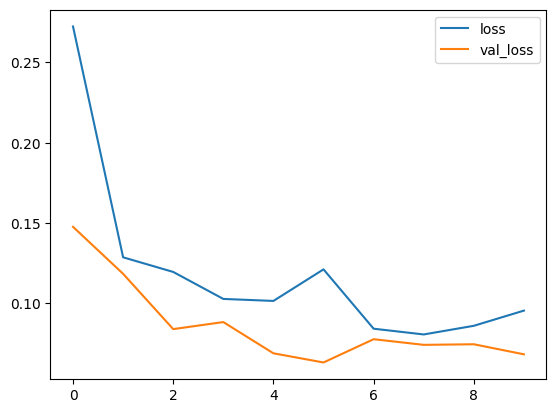

In [117]:
cnn_sliding = keras.Sequential()

cnn_sliding.add(keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Dropout(0.2))
cnn_sliding.add(keras.layers.Conv1D(32, 3, activation='relu'))
cnn_sliding.add(keras.layers.MaxPooling1D(2))
cnn_sliding.add(keras.layers.Dropout(0.2))
cnn_sliding.add(keras.layers.Flatten())
cnn_sliding.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
cnn_sliding.add(keras.layers.Dense(6, activation='softmax'))

nn_compile(cnn_sliding, 0.01)

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(cnn_sliding, train_X, train_y, val_X, val_y)

In [182]:
def cnn_test_results(cnn_sliding, x_test, y_test):
    xs = {}
    for activity in activities:
        xs[activity] = []

    label_encoder = LabelEncoder()
    label_encoder.fit(y_test)

    for i in range(len(x_test)):
        xs[y_test[i]].append(x_test[i])

    for activity in activities:
        xs[activity] = np.array(xs[activity])

    total = 0
    correct = 0
    for activity in activities:
        preds = cnn_sliding.predict(xs[activity], verbose=0)
        preds = np.argmax(preds, axis=1)
        accuracy = sum(preds == label_encoder.transform([activity])[0])/len(preds)
        print(activity + ': ' + str(accuracy*100) + '%')
        total += len(preds)
        correct += sum(preds == label_encoder.transform([activity])[0])
    print('total: ' + str(correct / total * 100) + '%')
     

In [183]:
cnn_test_results(cnn_sliding, X_test_window, y_test_window)

dws: 97.1371057928875%
ups: 96.76956209619526%
sit: 93.24837701370522%
std: 93.80677633194206%
wlk: 89.44256756756756%
jog: 84.54041337590321%
total: 92.4120717041071%


#### LSTM

Train on 162060 samples, validate on 54021 samples
Epoch 1/10


2023-12-02 21:31:52.310226: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/dense_48/kernel/v/Assign' id:3487 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_48/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_48/kernel/v, training_6/Adam/dense_48/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


161600/162060 [============================>.] - ETA: 0s - loss: 0.2484 - accuracy: 0.9197

2023-12-02 21:32:07.837065: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_3/mul' id:3269 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_48_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


162060/162060 [==============================] - 17s 106us/sample - loss: 0.2482 - accuracy: 0.9197 - val_loss: 0.1288 - val_accuracy: 0.9607
Epoch 2/10
162060/162060 [==============================] - 16s 98us/sample - loss: 0.0960 - accuracy: 0.9701 - val_loss: 0.0820 - val_accuracy: 0.9741
Epoch 3/10
162060/162060 [==============================] - 17s 103us/sample - loss: 0.0620 - accuracy: 0.9799 - val_loss: 0.0637 - val_accuracy: 0.9792
Epoch 4/10
162060/162060 [==============================] - 16s 100us/sample - loss: 0.0447 - accuracy: 0.9850 - val_loss: 0.0537 - val_accuracy: 0.9814
Epoch 5/10
162060/162060 [==============================] - 16s 97us/sample - loss: 0.0339 - accuracy: 0.9886 - val_loss: 0.0507 - val_accuracy: 0.9838
Epoch 6/10
162060/162060 [==============================] - 16s 97us/sample - loss: 0.0257 - accuracy: 0.9913 - val_loss: 0.0443 - val_accuracy: 0.9855
Epoch 7/10
162060/162060 [==============================] - 16s 98us/sample - loss: 0.0208 - acc

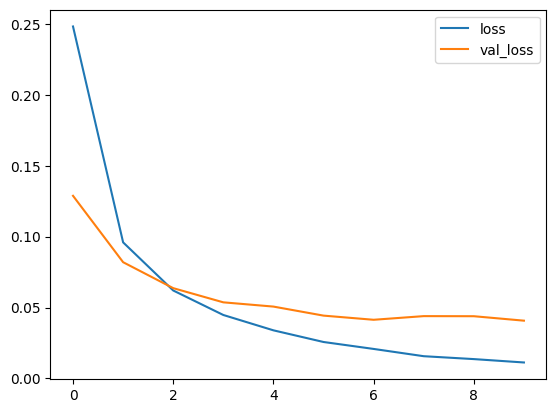

In [191]:
lstm = keras.Sequential()
lstm.add(keras.layers.Input((X_train_window.shape[1], X_train_window.shape[2])))
lstm.add(keras.layers.LSTM(6, input_shape=(X_train_window.shape[1], X_train_window.shape[2]), return_sequences=True))
lstm.add(keras.layers.Flatten())
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(6, activation='softmax'))

lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_X, val_X, train_y, val_y = train_test_split(X_train_window, y_train_window, shuffle=True)

nn_train(lstm, train_X, train_y, val_X, val_y)

In [192]:
cnn_test_results(lstm, X_test_window, y_test_window)

2023-12-02 21:35:27.860368: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_48/Softmax' id:3193 op device:{requested: '', assigned: ''} def:{{{node dense_48/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_48/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


dws: 98.61328561842988%
ups: 90.66762383345298%
sit: 95.13825438807406%
std: 95.2000982077093%
wlk: 93.3046683046683%
jog: 89.56477902873466%
total: 94.1487028212692%
